In [ ]:
# Install dependencies:
#!pip install torch torchvision matplotlib gym['box2d']

In [48]:
import os
import sys
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [49]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
from collections import deque, OrderedDict
import torch
import torch.nn as nn
import random
import copy
from IPython import display
plt.style.use('ggplot')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

<center> Environment Description </center>

`Name`   
LunarLander-v2

`Description`  
This environment explores the simulation of landing a space craft on the lunar surface. There are three engines on the bottom, both the sides of the spacecraft. The environment has discrete actions: engine on or off. There are two environment versions: on or off.
The landing pad is at the origin (0,0). The state vector is the co-ordinate position of the spacecraft in that frame. Fuel is infinite but each firing is penalized with a goal to help learn quick landings.


`Observation space`  
There are in total 8 states:

- `x-y`: cartesian coordinates of the lander
- `Vx-Vy`: Linear Velocities of the lander
- `theta`: Orientation angle of the lander
- 'Atheta': Angular velocities
-  'Cl,Cr': Booleans that say if lander's left and right legs are in contact with the ground.

`Action Space`  
     There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine

`Rewards`  
The reward function is defined as:

- Top of page to landing : 100-140 points
- If moving away from landing pad, it loses reward
- In case of a crash a reward of -100 is given.
- Each leg in contact with the ground is given +10 reward.
- Firing the main engine is -0.3 points for each frame and the side engines a penalty of -0.03 points.
- Correctly landing on the landing pad would be given a reward of +200 points.


`Starting State`  
The lander starts at the vertical top in the center.

`Episode Termination`   
The episode finishes if:
1) When the lander crashes into the surface.
2) the lander's x co-ordinate is > 1. (out of bounds)
3) the lander is not awake. (i.e. it doesn't move or do anything)

In [50]:
# Training the DQN. Has experience replay.

def plot_rewards(rewards,  goal_threshold_score, goal_threshold_episodes, enviroment_name, algorithm_name):
    display.clear_output(wait=True)
    # plot last 50 rewards handle 0 case
    if len(rewards) < goal_threshold_episodes:
        plt.plot(rewards)
    else:
        plt.plot(rewards[-goal_threshold_episodes:])

    # plot a goal line in red at 475
    plt.title(f"{enviroment_name} - {algorithm_name} Last {goal_threshold_episodes} episodes")
    plt.ylabel('Reward')
    plt.xlabel('-Episode')
    plt.plot([goal_threshold_score]*len(rewards), 'g', label='Goal')
    plt.legend()
    plt.show()

def train_model(env, model, loss_function, state_function , goal_threshold_score, goal_threshold_episodes, isDDQN = False,  replay_buffer_size = 5000, batch_size = 256, gamma = 0.89,  epochs = 3000, epsilon = 1, epsilon_decay = 0.99, epsilon_min = 0.001, 
update_target_every = 50 ):
  total_reward_list = []
  epsilons_epoch = []
  replay_buffer = deque(maxlen=replay_buffer_size)

  target_model = copy.deepcopy(model)
  target_model.load_state_dict(model.state_dict())
  
  j = 0

  episode_total = 0
  for i in range(epochs):
      episode_total = i + 1
      total_reward = 0
      s = env.reset()
      
      # one hot encoding
      state_1 = state_function(env, s)

      while(True):
          
          q_1 = model(state_1)

          # Take random action with probability epsilon or take the Q-network prediction in others
          if (random.random() < epsilon):
              action_1 = env.action_space.sample()
          else:
              action_1 = np.argmax(q_1.to('cpu').data.numpy())

          observation, reward, done, info = env.step(action_1)
          total_reward = total_reward + reward
    
          state_2 = state_function(env, observation)
          replay_buffer.append((state_1, action_1, reward, state_2, done))

          if(len(replay_buffer) >= batch_size):

                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*random.sample(replay_buffer, batch_size))
                state_batch = torch.cat(state_batch).to(device)
                action_batch = torch.Tensor(action_batch).to(device)
                reward_batch = torch.Tensor(reward_batch).to(device)
                next_state_batch = torch.cat(next_state_batch).to(device)
                done_batch = torch.Tensor(done_batch).to(device)

                q_1 = model(state_batch)
         
                X = q_1.gather(1, action_batch.long().unsqueeze(1)).squeeze(1)

                if(isDDQN):
                    th_t = model(next_state_batch)
                    max_action = torch.argmax(th_t, dim=1)
                    th_t_ = target_model(next_state_batch)
                    
                    # Y = reward_batch + gamma * (1 - done_batch) * th_t_[range(batch_size), max_action]
                    Y = reward_batch + gamma * (1 - done_batch) *  th_t_.gather(1, max_action.long().unsqueeze(1)).squeeze(1)
                   
                else:
                    q_2 = target_model(next_state_batch)
                    Y = reward_batch + gamma * (1 - done_batch) * torch.max(q_2,  dim= 1)[0]

                loss = loss_function(X, Y.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        

          state_1 = state_2
          j += 1
          if(j % update_target_every == 0):
              target_model.load_state_dict(model.state_dict())

          if done:
              break
      
      plot_rewards(total_reward_list, goal_threshold_score, goal_threshold_episodes, env.unwrapped.spec.id, 'Double DQN' if isDDQN else 'DQN')
      
      print(f"Epoch: {i} \t Total Reward: {total_reward} \t Epsilon: {epsilon}")
      total_reward_list.append(total_reward)

      # stop if goal is reached
      epsilons_epoch.append(epsilon)
      goal_threshold = lambda rewards:  len(rewards) > goal_threshold_episodes and np.mean(rewards[- goal_threshold_episodes:]) > goal_threshold_score

      if goal_threshold(total_reward_list):
            print("Goal Reached!!")
            break
    
      epsilon = max(epsilon * epsilon_decay, epsilon_min)
      
    
  return episode_total, total_reward_list, epsilons_epoch

In [51]:
def test_model(model, episodes, env, state_function):
    status_list = []
    total_reward_list = []
    for i in range(episodes):
        total_reward = 0
        s = env.reset()
        state = state_function(env, s)
        total_reward = 0
        step = 0
        while(True):
            step+=1
            QApprox = model(state)
            greedy_action_ = np.argmax(QApprox.to('cpu').data.numpy())
            # print(f'For Step : {step}; Taking action: {greedy_action_}')
            observation, reward, done,_ = env.step(greedy_action_)
            total_reward += reward
            state = state_function(env, observation)
            if done:
                env.render()
                status_list.append(True)
                break
 
        total_reward_list.append(total_reward)
    return status_list, total_reward_list

In [52]:
def visualize_training(total_reward_list, epochs, epsilons_epoch, environment_name, algorithm_name):
    plt.figure(figsize=(10,10))

    plt.title(f'{environment_name}-{algorithm_name} Rewards with epoch')
    plt.plot(range(1, len(epsilons_epoch) + 1),total_reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards per Epoch')
    plt.show()

    plt.plot(range(len(epsilons_epoch)), epsilons_epoch)
    plt.title(f'{environment_name}-{algorithm_name} with  Epsilon Decay')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilons')
    plt.legend([algorithm_name])
    plt.show()

def visualize_testing(epochs, rewards, environment_name, algorithm_name):
    plt.show()
    plt.plot(range(epochs), rewards)
    plt.title(f'{environment_name}-{algorithm_name} Episodic Reward on trained agent')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend([algorithm_name])
    plt.show()

def build_model(hyperparameters):
    dict = OrderedDict()
    dict.update({'Input layer': torch.nn.Linear(hyperparameters['state_dim'], hyperparameters['layer_dim'][0])})
    dict.update({f'ReLU 0': torch.nn.ReLU()})

    #  Make torch neural network from layer_dim and hidden_dim 
    for i in range(len(hyperparameters['layer_dim'])-1):
        dict.update({f'Hidden layer {i+1}': torch.nn.Linear(hyperparameters['layer_dim'][i], hyperparameters['layer_dim'][i+1])})
        # activation function
        dict.update({f'ReLU {i+1}': torch.nn.ReLU()})

    dict.update({'Output layer': torch.nn.Linear(hyperparameters['layer_dim'][-1], hyperparameters['action_dim'])})
    return torch.nn.Sequential(dict)
    


<center> Training the DQN Agent </center>

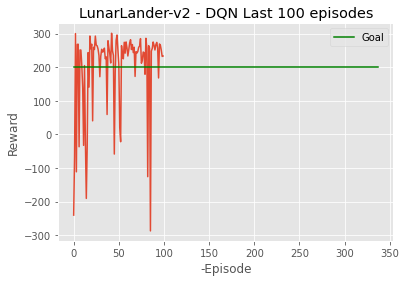

Epoch: 338 	 Total Reward: 300.3512396455469 	 Epsilon: 0.020417379446695434
Goal Reached!!


In [53]:
# Lunar lander

env = gym.make('LunarLander-v2')
env.reset()

# possible actions
print(f'Possible actions are Discrete: {env.action_space}')

# observation space
print(f'observation space consists of {env.observation_space}')

# goals
print(f'Goal threshold of the environment: {env.spec.reward_threshold}')


lunar_lander_hyperparameters  = {
    'state_dim': env.observation_space.shape[0],
    'action_dim': env.action_space.n,
    'layer_dim': [150, 120],
    'lr': 0.001,
    'episodes': 400,
    'gamma': 0.99,
    'replay_batch_size': 64,
    'epsilon': 1,
    'epsilon_min': 0.01,
    'replay_buffer_size': 100000,
    'update_target_every': 4,
    'goal_threshold_score': env.spec.reward_threshold,
    'goal_threshold_episodes': 100,
}

model = build_model(lunar_lander_hyperparameters)
model.to(device)

print('Summary of Layers in the employed network: ')
print(model)

optimizer = torch.optim.Adam(model.parameters(), lunar_lander_hyperparameters['lr'])

loss_function = torch.nn.MSELoss()

state_function = lambda env, curr_state: curr_state.to(device) if torch.is_tensor(curr_state) else torch.from_numpy(curr_state.reshape(1, 8)).float().to(device)

# mean of last 10 episodes is greater than 470

epochs,total_reward_list_dqn, epsilons_epoch_dqn =  train_model(env, model, loss_function, state_function= state_function, epochs= lunar_lander_hyperparameters['episodes'], gamma= lunar_lander_hyperparameters['gamma'], epsilon= lunar_lander_hyperparameters['epsilon'],
 replay_buffer_size= lunar_lander_hyperparameters['replay_buffer_size'], 
 batch_size = lunar_lander_hyperparameters['replay_batch_size'], update_target_every= lunar_lander_hyperparameters['update_target_every'],
  epsilon_min= lunar_lander_hyperparameters['epsilon_min'], 
 epsilon_decay= (0.01 / 1)**(1/lunar_lander_hyperparameters['episodes']), goal_threshold_score = lunar_lander_hyperparameters['goal_threshold_score'] ,goal_threshold_episodes =  lunar_lander_hyperparameters['goal_threshold_episodes']) 


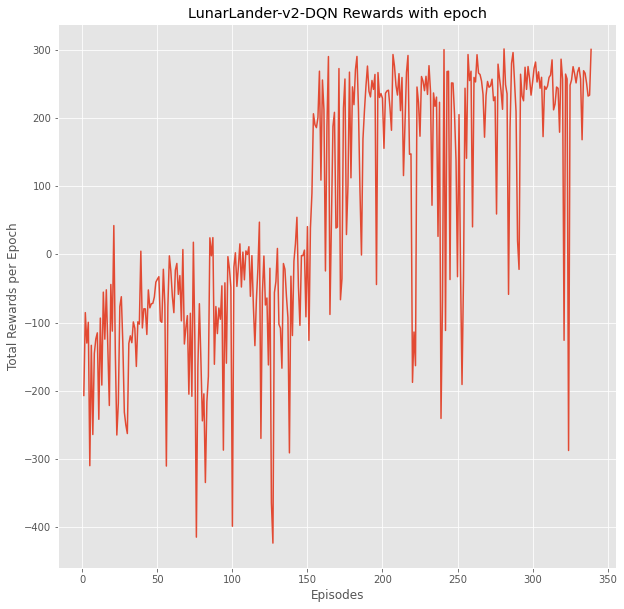

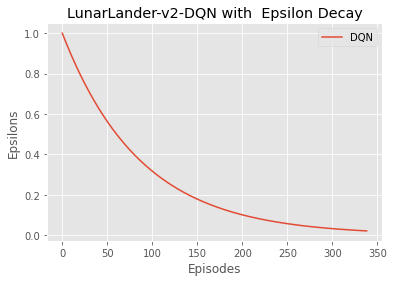

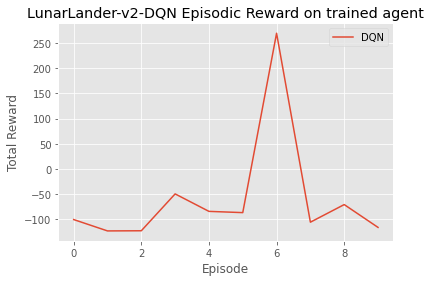

In [54]:
visualize_training(total_reward_list_dqn, epochs, epsilons_epoch_dqn, 'LunarLander-v2', 'DQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'LunarLander-v2', 'DQN')

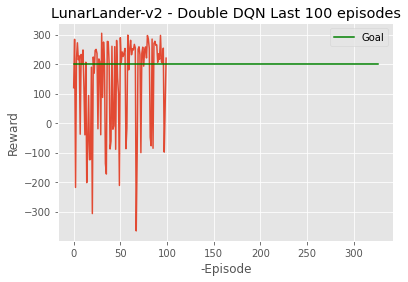

Epoch: 327 	 Total Reward: 237.14957094101064 	 Epsilon: 0.02317394649968494


In [ ]:
# Lunar lander using Double DQN

epochs,total_reward_list_ddqn, epsilons_epoch_ddqn =  train_model(env, model, loss_function, state_function= state_function, epochs= lunar_lander_hyperparameters['episodes'], gamma= lunar_lander_hyperparameters['gamma'], epsilon= lunar_lander_hyperparameters['epsilon'],
 replay_buffer_size= lunar_lander_hyperparameters['replay_buffer_size'], 
 batch_size = lunar_lander_hyperparameters['replay_batch_size'], update_target_every= lunar_lander_hyperparameters['update_target_every'],
  epsilon_min= lunar_lander_hyperparameters['epsilon_min'], 
 epsilon_decay= (0.01 / 1)**(1/lunar_lander_hyperparameters['episodes']), goal_threshold_score = lunar_lander_hyperparameters['goal_threshold_score'] ,goal_threshold_episodes =  lunar_lander_hyperparameters['goal_threshold_episodes'],
 isDDQN= True) 

visualize_training(total_reward_list_ddqn, epochs, epsilons_epoch_ddqn, 'LunarLander-v2', 'DDQN')
test_epochs = 10
# Testing the model
complete, test_reward_list = test_model(model, env = env, state_function= state_function, episodes=test_epochs)

visualize_testing(test_epochs,test_reward_list, 'LunarLander-v2', 'DDQN')


<center>Comparing DQN and DDQN on LunarLander-v2</center>

In [ ]:
# comparing dqn and ddqn on the LunarLander-v2

plt.plot(range(len(epsilons_epoch_dqn)), total_reward_list_dqn, label='DQN')
plt.plot(range(len(epsilons_epoch_ddqn)), total_reward_list_ddqn, label='DDQN')
plt.title('Comparison of DQN and DDQN on LunarLander-v2')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

In [ ]:
env.close()